<h1>Introduction</h1>

In this document, we present how to build a bayes classification model for reviews on Amazon's product (positive or negative review). The input data are the comments from customers. We choose Android's app as the category to build the model.

<h1>Explore dataset </h1>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB 


In [2]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The input dataset is downloaded at http://jmcauley.ucsd.edu/data/amazon/.
The code to read input into dataframe and calculate average is also copied from that site.

In [3]:
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')
# Compute average rating
ratings = []

for review in parse("reviews_Apps_for_Android_5.json.gz"):
    ratings.append(review['overall'])

print ("average rating", sum(ratings) / len(ratings))
df = getDF('reviews_Apps_for_Android_5.json.gz')
df.describe()

average rating 3.968930999539138


,overall,unixReviewTime
count,752937.000000,7.529370e+05
mean,3.968931,1.368442e+09
std,1.342484,2.342230e+07
min,1.000000,1.134778e+09
25%,3.000000,1.354147e+09
50%,5.000000,1.370477e+09
75%,5.000000,1.388448e+09
max,5.000000,1.406074e+09


In [4]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"


In [5]:
df.shape


(752937, 9)

From the header, we will see the reviewText, overall, and summary have the necessary information about the review on each product. Others columns don't have helpful information, so we will drop them. 

In [6]:
data = df[['reviewText', 'summary', 'overall']]
data.head(2)

,reviewText,summary,overall
0,"Loves the song, so he really couldn't wait to ...",Really cute,3.0
1,"Oh, how my little grandson loves this app. He'...",2-year-old loves it,5.0


<h1>Convert text data to vector and build model </h1>
We need to transform the text data to vector data before doing classification. I reference this website http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

<h3>Model 1: </h3>

Input: text review
Output: 5 levels of overall review from 1 to 5

In [7]:
train=data.sample(frac=0.7,random_state=200)
test=data.drop(train.index)

In [8]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [9]:
text_clf.fit(train.reviewText, train.overall)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

0.532523762512
             precision    recall  f1-score   support

        1.0       0.79      0.16      0.27     23690
        2.0       0.00      0.00      0.00     13212
        3.0       0.45      0.01      0.01     25513
        4.0       0.34      0.02      0.03     47596
        5.0       0.53      1.00      0.69    115870

avg / total       0.48      0.53      0.39    225881

Confusion matrix:
             precision    recall  f1-score   support

       -1.0       0.90      0.12      0.21     36902
        0.0       0.45      0.01      0.01     25513
        1.0       0.74      1.00      0.85    163466

avg / total       0.73      0.74      0.65    225881



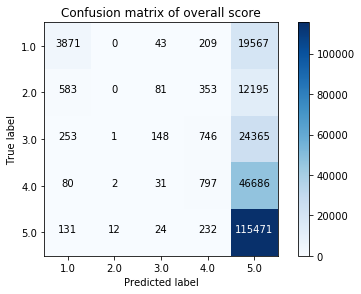

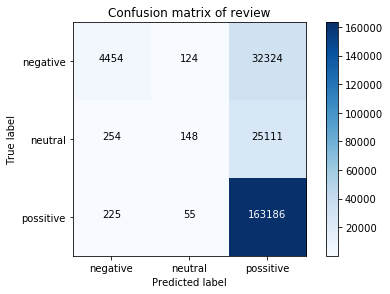

In [10]:
predicted = text_clf.predict(test.reviewText)
print(np.mean(predicted == test.overall))
print(metrics.classification_report(test.overall, predicted))

cnf_matrix = metrics.confusion_matrix(test.overall, predicted)
print('Confusion matrix:')
class_names = text_clf.classes_
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of overall score')

test['label'] = np.sign(test.overall - 3)
predicted_label = np.sign(predicted - 3)
print(metrics.classification_report(test.label, predicted_label))
# Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(test.label, predicted_label)

class_names = ['negative', 'neutral', 'possitive']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of review')

there are so many positive reviews that it overwhelm the negative reviews. This model is failed to classify overall score.

<h3> Model 2 </h3>
Because sampling size is imbalanced, we will try to solve this before building model

In [11]:
p5_indices = data[data.overall == 5.0].index
random_indices = np.random.choice(p5_indices, 80000, replace=False)
p5_sample = data.loc[random_indices]
# p5_sample.head(1)

p4_indices = data[data.overall == 4.0].index
random_indices = np.random.choice(p4_indices, 80000, replace=False)
p4_sample = data.loc[random_indices]
# p4_sample.head(1)

temp = data[data.overall == 2.0]
random_indices = np.random.choice(temp.index, 80000, replace=True)
p2_sample = temp.loc[random_indices]
# p2_sample.head(1)

In [33]:
frame = [data[data.overall==1], p2_sample, data[data.overall==3], p4_sample, p5_sample]
newdata = pd.concat(frame)
newdata.overall.value_counts()

3.0    85121
5.0    80000
4.0    80000
2.0    80000
1.0    78713
Name: overall, dtype: int64

In [34]:
train=newdata.sample(frac=0.7,random_state=200)
test=newdata.drop(train.index)

In [36]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
 ])

In [37]:
text_clf.fit(train.reviewText, train.overall)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [38]:
print(np.mean(text_clf.predict(newdata.reviewText) == newdata.overall))

0.54894585399


0.494999134466
             precision    recall  f1-score   support

        1.0       0.69      0.58      0.63     23739
        2.0       0.16      0.36      0.22      6645
        3.0       0.45      0.52      0.48     25421
        4.0       0.46      0.35      0.40     24089
        5.0       0.63      0.57      0.60     24088

avg / total       0.53      0.49      0.51    103982

Confusion matrix:


C:\Users\a16508\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


             precision    recall  f1-score   support

       -1.0       0.67      0.76      0.71     30384
        0.0       0.45      0.52      0.48     25421
        1.0       0.83      0.69      0.75     48177

avg / total       0.69      0.67      0.68    103982



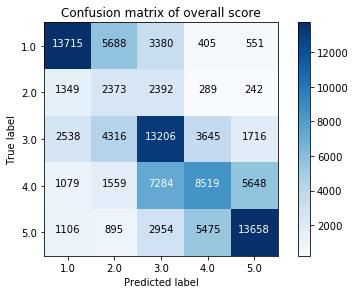

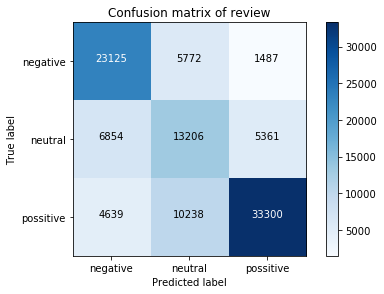

In [39]:
predicted = text_clf.predict(test.reviewText)
print(np.mean(predicted == test.overall))
print(metrics.classification_report(test.overall, predicted))
cnf_matrix = metrics.confusion_matrix(test.overall, predicted)
print('Confusion matrix:')
class_names = text_clf.classes_
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of overall score')

test['label'] = np.sign(test.overall - 3)
predicted_label = np.sign(predicted - 3)
print(metrics.classification_report(test.label, predicted_label))
# Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(test.label, predicted_label)

class_names = ['negative', 'neutral', 'possitive']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of review')

When running on test set, the f-score is 0.68. The are many positive review 10.238 which are classified as neutral. The are many negative review 5,772 which are classified as neutral. The data has noise information.

<h3> Model 3 </h3>

choosing summary, not reviewText as input may improve the model.

In [40]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf.fit(train.summary, train.overall)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [41]:
print(np.mean(text_clf.predict(newdata.summary) == newdata.overall))

0.52601068756


0.492460233502
             precision    recall  f1-score   support

        1.0       0.67      0.58      0.62     23739
        2.0       0.16      0.38      0.22      6645
        3.0       0.49      0.42      0.45     25421
        4.0       0.46      0.47      0.46     24089
        5.0       0.60      0.55      0.57     24088

avg / total       0.53      0.49      0.51    103982

Confusion matrix:


C:\Users\a16508\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


             precision    recall  f1-score   support

       -1.0       0.64      0.76      0.70     30384
        0.0       0.49      0.42      0.45     25421
        1.0       0.79      0.75      0.77     48177

avg / total       0.67      0.67      0.67    103982



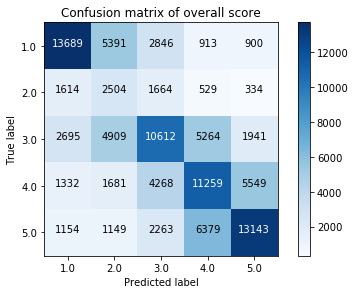

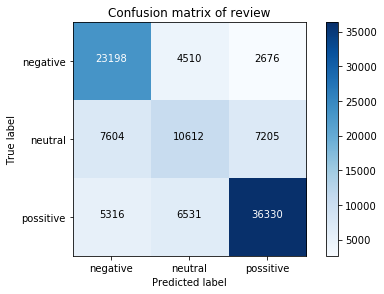

In [42]:
predicted = text_clf.predict(test.summary)
print(np.mean(predicted == test.overall))
print(metrics.classification_report(test.overall, predicted))
cnf_matrix = metrics.confusion_matrix(test.overall, predicted)
print('Confusion matrix:')
class_names = text_clf.classes_
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of overall score')

test['label'] = np.sign(test.overall - 3)
predicted_label = np.sign(predicted - 3)
print(metrics.classification_report(test.label, predicted_label))
# Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(test.label, predicted_label)

class_names = ['negative', 'neutral', 'possitive']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of review')

The result is env worse.

we will try to make 3 label only before running model to compare

In [47]:
newdata["label"] = np.sign(newdata.overall - 3)
print(newdata.label.value_counts())
newdata.head(2)
train=newdata.sample(frac=0.7,random_state=200)
test=newdata.drop(train.index)
train.head(2)

 1.0    160000
-1.0    158713
 0.0     85121
Name: label, dtype: int64


,reviewText,summary,overall,label
110210,Any way you can not use it if you have a Kindl...,does not work,1.0,-1.0
582758,This was my favorite one of these games. I lik...,Fun,5.0,1.0


In [48]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf.fit(train.reviewText, train.label)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [51]:
print(np.mean(text_clf.predict(newdata.reviewText) == newdata.label))

0.691080988723


0.651680098479
             precision    recall  f1-score   support

       -1.0       0.56      0.89      0.69     30384
        0.0       0.72      0.01      0.03     25421
        1.0       0.73      0.84      0.78     48177

avg / total       0.68      0.65      0.57    103982

Confusion matrix:


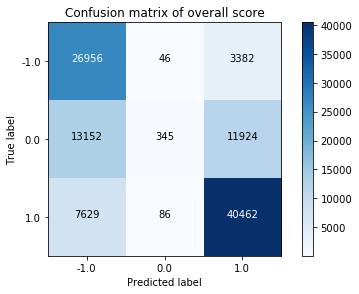

In [52]:
predicted = text_clf.predict(test.reviewText)
print(np.mean(predicted == test.label))
print(metrics.classification_report(test.label, predicted))
cnf_matrix = metrics.confusion_matrix(test.label, predicted)
print('Confusion matrix:')
class_names = text_clf.classes_
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of overall score')

<h3>Model 4: </h3>
Use SVM

We will try SVM to run classification to compare with Bayes to see why Bayes has so low performance.

In [53]:
data.overall.value_counts()

5.0    386637
4.0    158081
3.0     85121
1.0     78713
2.0     44385
Name: overall, dtype: int64

In [54]:
w = {}
w[1.0]=2
w[2.0]=1
w[3.0]=2
w[4.0]=4
w[5.0]=8
w

{1.0: 2, 2.0: 1, 3.0: 2, 4.0: 4, 5.0: 8}

In [55]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2', class_weight = w,
                                            alpha=1e-3, random_state=42)),
 ])
text_clf.fit(train.reviewText, train.overall) 

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [56]:
predicted = text_clf.predict(data.reviewText)
np.mean(predicted == data.overall)

0.59218633165855838

0.431853590044
             precision    recall  f1-score   support

        1.0       0.71      0.52      0.60     23739
        2.0       0.00      0.00      0.00      6645
        3.0       0.72      0.07      0.13     25421
        4.0       0.36      0.41      0.38     24089
        5.0       0.37      0.87      0.52     24088

avg / total       0.51      0.43      0.38    103982



C:\Users\a16508\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:


C:\Users\a16508\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


             precision    recall  f1-score   support

       -1.0       0.82      0.47      0.60     30384
        0.0       0.72      0.07      0.13     25421
        1.0       0.56      0.98      0.72     48177

avg / total       0.68      0.61      0.54    103982



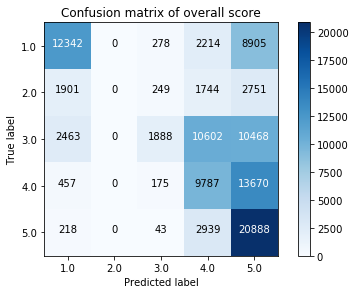

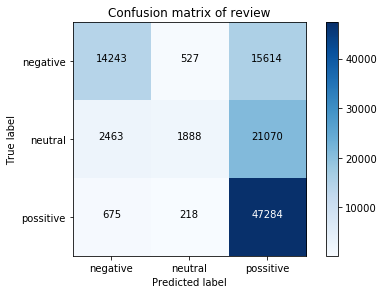

In [57]:
predicted = text_clf.predict(test.reviewText)
print(np.mean(predicted == test.overall))
print(metrics.classification_report(test.overall, predicted))
# Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(test.overall, predicted)
print('Confusion matrix:')
class_names = text_clf.classes_
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of overall score')

test['label'] = np.sign(test.overall - 3)
predicted_label = np.sign(predicted - 3)
print(metrics.classification_report(test.label, predicted_label))
# Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(test.label, predicted_label)

class_names = ['negative', 'neutral', 'possitive']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix of review')

The SVM model is still not good.